In [44]:
import pickle
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy import interpolate, integrate
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Add custom library path (update this path as needed)
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import GCaMPData, LimbData, Frame, Clip, Experiment

In [45]:
# Data folder path
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'

# … your constants above …
FRAME_RATE = 30   # frames per second
BOUT_END_TIME = 2 # sec
POST_BOUT_TIME = 6 # sec
FULL_WINDOW = BOUT_END_TIME + POST_BOUT_TIME
BOUT_END_FRAMES = BOUT_END_TIME * FRAME_RATE
POST_BOUT_FRAMES = POST_BOUT_TIME * FRAME_RATE
FULL_WINDOW_FRAMES = FULL_WINDOW * FRAME_RATE

# build a time vector from -POST_BOUT_TIME to +BOUT_END_TIME at 1/FRAME_RATE steps
common_t = np.arange(-BOUT_END_TIME,
                     POST_BOUT_TIME + 1.0/FRAME_RATE,
                     1.0/FRAME_RATE)


In [46]:
def local_average_calculator(trace, window_sec=POST_BOUT_TIME):
    """
    Compute the mean of the first `window_sec` seconds of a trace.
    """
    n_points = int(window_sec * FRAME_RATE)
    return np.mean(trace[:n_points]) if len(trace) >= n_points else np.mean(trace)

In [47]:
def load_experiments_from_folder(folder):
    experiments = []
    for filename in os.listdir(folder):
        if filename.endswith(".pkl"):
            path = os.path.join(folder, filename)
            with open(path, 'rb') as f:
                experiments.append(pickle.load(f))
            print(f"Loaded: {filename}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments


def get_sapap_genotype(genotype_string):
    tag = "Sapap("
    if tag in genotype_string:
        start = genotype_string.find(tag) + len(tag)
        end = genotype_string.find(")", start)
        return genotype_string[start:end]
    return None


def group_experiments_by_genotype(experiments):
    wt, ko = [], []
    for exp in experiments:
        genotype = get_sapap_genotype(exp.Genotype)
        if genotype == "WT":
            wt.append(exp)
        elif genotype == "KO":
            ko.append(exp)
        else:
            print(f"Warning: Unknown Sapap genotype for {exp.Mouse_id}")
    print(f"Number of WT mice: {len(wt)} | KO mice: {len(ko)}")
    return wt, ko


In [48]:
# Bout Detection
def detect_bouts(experiments, min_duration_sec, max_duration_sec):
    """
    Find all grooming bouts whose duration is between min_duration_sec and max_duration_sec.
    """
    minimum_duration_frames = min_duration_sec * FRAME_RATE
    maximum_duration_frames = max_duration_sec * FRAME_RATE

    total_bouts = 0
    bouts_by_mouse = {}

    for experiment in experiments:
        annotations = experiment.Grooming_annotations or []
        valid_bouts = [
            (start_frame, end_frame)
            for start_frame, end_frame in annotations
            if minimum_duration_frames <= (end_frame - start_frame) <= maximum_duration_frames
        ]
        bouts_by_mouse[experiment.Mouse_id] = valid_bouts
        total_bouts += len(valid_bouts)

    print(f"Valid bouts ({min_duration_sec}-{max_duration_sec}s): {total_bouts}")
    return total_bouts, bouts_by_mouse


# Bout Detection and Post-Bout Filtering
def filter_by_post_activity(experiments, bouts_by_mouse, post_activity_sec):
    """
    Remove any bout that is followed by another bout within post_activity_sec seconds.
    Then extract the full window around each remaining bout:
      from (bout end – BOUT_END_TIME)  to  (bout end + POST_BOUT_TIME).
    """
    post_activity_frames = post_activity_sec * FRAME_RATE
    filtered_bouts = {}
    filtered_traces = {}

    for experiment in experiments:
        annotations = experiment.Grooming_annotations or []
        valid_bouts = bouts_by_mouse.get(experiment.Mouse_id, [])

        kept_bouts = []
        trace_list = []

        for start_frame, end_frame in valid_bouts:
            # drop if there’s another bout starting within post_activity_frames
            has_following_bout = any(
                (other_start >= end_frame) and (other_start < end_frame + post_activity_frames)
                for other_start, _ in annotations
                if (other_start, _) != (start_frame, end_frame)
            )
            if not has_following_bout:
                kept_bouts.append((start_frame, end_frame))

                # NEW: define full window around the *end* of the bout
                window_start = end_frame - BOUT_END_FRAMES
                window_end   = end_frame + POST_BOUT_FRAMES

                # clamp to 0..end_of_recording
                window_start = max(0, window_start)
                # no need to clamp window_end here; get_gcamp_data_Z_score will cap it

                # pull the *entire* full window
                trace, times = experiment.get_gcamp_data_Z_score(
                    window_start,
                    window_end
                )
                trace_list.append((trace, times))

        filtered_bouts[experiment.Mouse_id] = kept_bouts
        filtered_traces[experiment.Mouse_id] = trace_list
        print(f"Mouse {experiment.Mouse_id}: {len(kept_bouts)} bouts after post-activity filtering")

    return filtered_bouts, filtered_traces


In [49]:
# Alignment and Averaging Functions
def align_traces(traces_dict, bouts_dict):
    """
    Shift every trace so that its bout‐end falls at time 0.
    """
    aligned = {}
    for mouse_id, traces in traces_dict.items():
        aligned[mouse_id] = []
        for (trace, t), (start_frame, end_frame) in zip(traces, bouts_dict.get(mouse_id, [])):
            # subtract end_time (in seconds) to put the bout end at zero
            aligned_time = t - (end_frame / FRAME_RATE)
            aligned[mouse_id].append((trace, aligned_time))
    return aligned



def compute_avg_traces(aligned, common_t):
    mouse_avg, counts = {}, {}
    all_tr = []
    for m, trs in aligned.items():
        if not trs:
            continue
        its = [np.interp(common_t, t, tr) for tr,t in trs]
        arr = np.vstack(its)
        avg = arr.mean(0)
        std = arr.std(0)
        sem = std/np.sqrt(arr.shape[0])
        mouse_avg[m] = {'avg':avg, 'std':std, 'sem':sem}
        counts[m] = arr.shape[0]
        all_tr.extend(its)
    grp = np.vstack(all_tr) if all_tr else np.array([])
    if grp.size:
        gavg = grp.mean(0); gstd = grp.std(0); gsem = gstd/np.sqrt(grp.shape[0])
    else:
        gavg=gstd=gsem=None
    return mouse_avg, counts, gavg, gstd, gsem

In [50]:
def plot_group_corrected_traces(common_t,
                                mouse_avg_dict,
                                counts_dict,
                                group_avg,
                                window_sec=POST_BOUT_TIME,
                                group_label='WT',
                                mouse_color='gray',
                                group_color='black'):
    """
    Plot each mouse’s corrected avg trace (avg - local avg) with n in legend,
    plus the group’s corrected avg trace, and a vertical line at time=0.
    """
    plt.figure(figsize=(8, 6))

    # individual mice
    for mouse_id, stats in mouse_avg_dict.items():
        avg_trace = stats['avg']
        local_avg = local_average_calculator(avg_trace, window_sec)
        corrected = avg_trace - local_avg
        n_bouts = counts_dict.get(mouse_id, 0)
        plt.plot(common_t,
                 corrected,
                 color=mouse_color,
                 alpha=0.3,
                 label=f'{mouse_id} (n={n_bouts})')

    # group average
    local_avg_group = local_average_calculator(group_avg, window_sec)
    corrected_group = group_avg - local_avg_group
    total_bouts = sum(counts_dict.values())
    plt.plot(common_t,
             corrected_group,
             color=group_color,
             lw=2.5,
             label=f'{group_label} (n={total_bouts})')

    # vertical line at bout end
    plt.axvline(0, color='black', linestyle='--', lw=1)
    plt.axhline(0, color='black', linestyle='--', lw=1)
    plt.xlabel('Time from bout end (s)', fontsize=14)
    plt.ylabel('Corrected GCaMP Z score', fontsize=14)
    plt.title(f'{group_label} — Corrected Avg Traces', fontsize=16)
    plt.legend(fontsize=10, loc='best')
    plt.tight_layout()
    plt.show()


def plot_wt_ko_corrected(common_t,
                         wt_mouse_avg, wt_counts, wt_gavg,
                         ko_mouse_avg, ko_counts, ko_gavg,
                         window_sec=POST_BOUT_TIME):
    """
    Plot WT in blue and KO in red.
    """
    plot_group_corrected_traces(common_t,
                                wt_mouse_avg,
                                wt_counts,
                                wt_gavg,
                                window_sec=window_sec,
                                group_label='Avg',
                                mouse_color='lightblue',
                                group_color='blue')

    plot_group_corrected_traces(common_t,
                                ko_mouse_avg,
                                ko_counts,
                                ko_gavg,
                                window_sec=window_sec,
                                group_label='Avg',
                                mouse_color='lightcoral',
                                group_color='red')

def plot_group_avg_with_sem(common_t,
                            wt_group_avg, wt_group_sem,
                            ko_group_avg, ko_group_sem,
                            wt_counts, ko_counts,
                            window_sec=POST_BOUT_TIME):
    """
    Plot WT vs KO group‐corrected avg traces with SEM shading.
    """
    plt.figure(figsize=(12, 6))

    # WT corrected + SEM
    wt_local = local_average_calculator(wt_group_avg, window_sec)
    wt_corr = wt_group_avg - wt_local
    n_wt = sum(wt_counts.values())
    plt.plot(common_t, wt_corr,
             color='blue', lw=2.5,
             label=f"WT group (mice ={len(wt_group)}, bouts={n_wt})")
    plt.fill_between(common_t,
                     wt_corr - wt_group_sem,
                     wt_corr + wt_group_sem,
                     color='blue', alpha=0.3)

    # KO corrected + SEM
    ko_local = local_average_calculator(ko_group_avg, window_sec)
    ko_corr = ko_group_avg - ko_local
    n_ko = sum(ko_counts.values())
    plt.plot(common_t, ko_corr,
             color='red', lw=2.5,
             label=f"KO group (mice= {len(ko_group)}, bouts={n_ko})")
    plt.fill_between(common_t,
                     ko_corr - ko_group_sem,
                     ko_corr + ko_group_sem,
                     color='red', alpha=0.3)

    # mark bout end
    plt.axvline(0, color='grey', linestyle='--', lw=1)
    plt.axhline(0, color='grey', linestyle='--', lw=1)
    plt.xlabel('Time(s)', fontsize=14)
    plt.ylabel('Z score (GCaMP8s)', fontsize=14)
    #plt.title('Group‐corrected Average Traces ±SEM', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
Number of WT mice: 5 | KO mice: 8
Valid bouts (2-999s): 147
Mouse M329: 7 bouts after post-activity filtering
Mouse M344: 9 bouts after post-activity filtering
Mouse M354: 22 bouts after post-activity filtering
Mouse M365: 4 bouts after post-activity filtering
Mouse M511: 9 bouts after post-activity filtering
Valid bouts (2-999s): 286
Mouse M338: 12 bouts after post-activity filtering
Mouse M352: 15 bouts after post-activity filtering
Mouse M406: 10 bouts after post-activity filtering
Mouse M407: 23 bouts after post-activity filtering
Mouse M416: 9 bouts after po

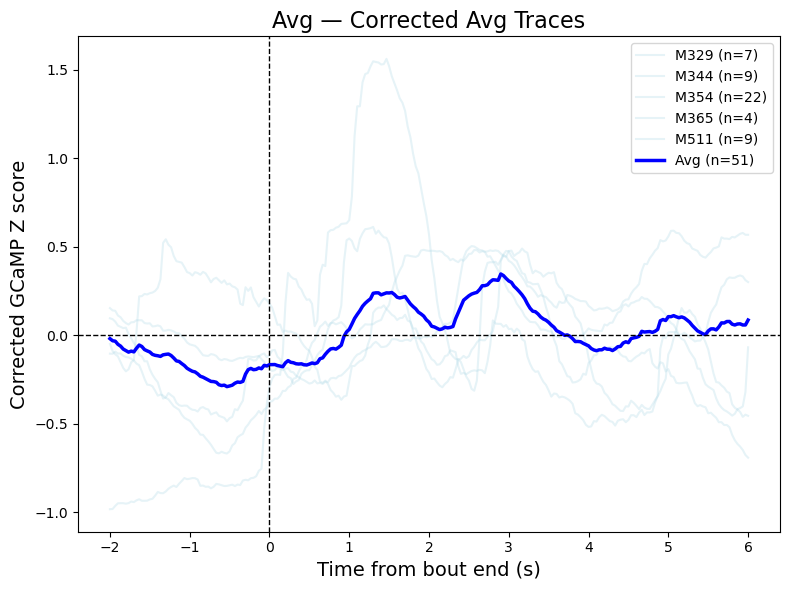

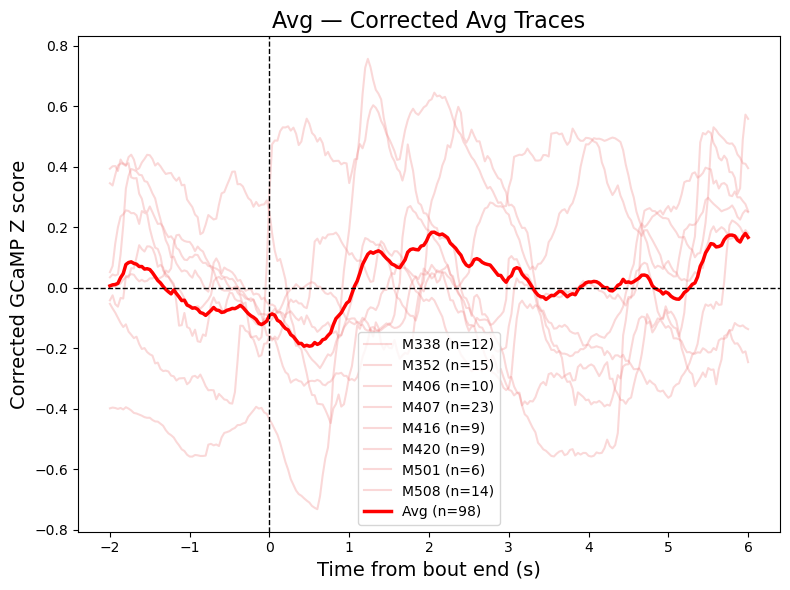

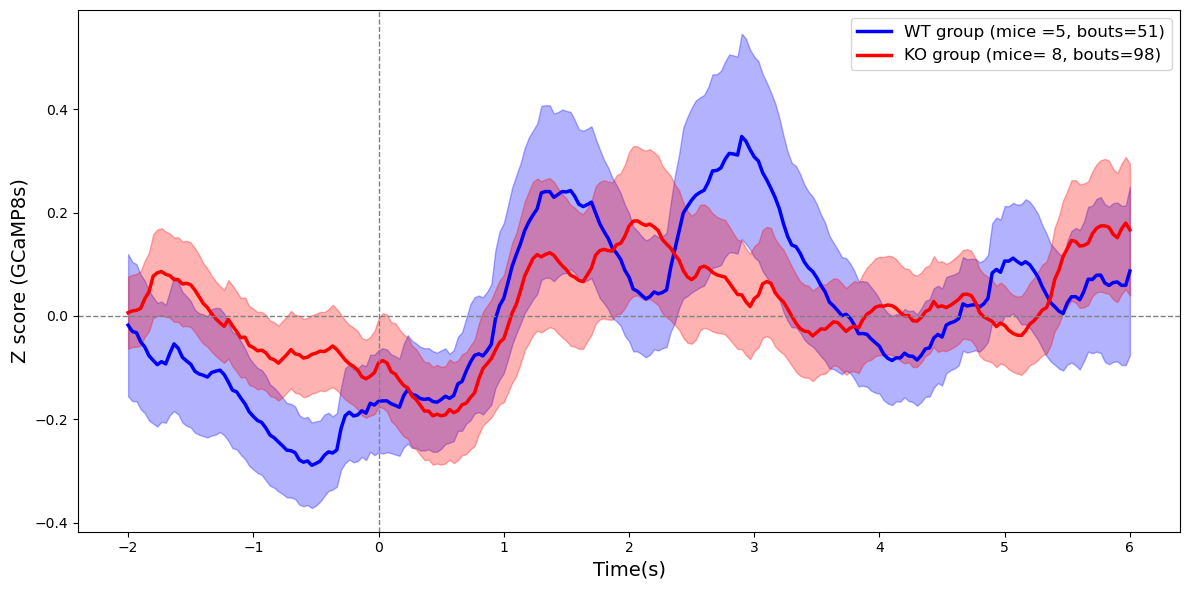

In [51]:
if __name__ == "__main__":
    experiments = load_experiments_from_folder(DATA_FOLDER)
    wt_group, ko_group = group_experiments_by_genotype(experiments)

    # --- WT pipeline ---
    # only keep bouts ≥ BOUT_END_TIME seconds
    _, wt_bouts = detect_bouts(wt_group,
                               min_duration_sec=BOUT_END_TIME,
                               max_duration_sec=999)  
    wt_bouts_filt, wt_traces = filter_by_post_activity(
        wt_group, wt_bouts, POST_BOUT_TIME
    )
    wt_aligned = align_traces(wt_traces, wt_bouts_filt)
    wt_mouse_avg, wt_counts, wt_gavg, wt_gstd, wt_gsem = compute_avg_traces(
        wt_aligned, common_t
    )

    # --- KO pipeline (same) ---
    _, ko_bouts = detect_bouts(ko_group,
                               min_duration_sec=BOUT_END_TIME,
                               max_duration_sec=999)
    ko_bouts_filt, ko_traces = filter_by_post_activity(
        ko_group, ko_bouts, POST_BOUT_TIME
    )
    ko_aligned = align_traces(ko_traces, ko_bouts_filt)
    ko_mouse_avg, ko_counts, ko_gavg, ko_gstd, ko_gsem = compute_avg_traces(
        ko_aligned, common_t
    )

    plot_wt_ko_corrected(common_t,
                        wt_mouse_avg, wt_counts, wt_gavg,
                        ko_mouse_avg, ko_counts, ko_gavg)

    plot_group_avg_with_sem(common_t,
                        wt_gavg, wt_gsem,
                        ko_gavg, ko_gsem,
                        wt_counts, ko_counts)


Females vs Males

In [52]:
def get_sex(exp):
    """
    Normalize sex string to 'Female' or 'Male'.
    Falls back to None if missing/unknown.
    """
    s = getattr(exp, 'Sex', None)
    if not s:
        return None
    s = str(s).strip().lower()
    if s in {'f', 'female'}:
        return 'Female'
    if s in {'m', 'male'}:
        return 'Male'
    return None

def group_experiments_by_sex(experiments):
    females, males = [], []
    for exp in experiments:
        s = get_sex(exp)
        if s == 'Female':
            females.append(exp)
        elif s == 'Male':
            males.append(exp)
        else:
            print(f"Warning: Unknown sex for {exp.Mouse_id}")
    print(f"Number of Female mice: {len(females)} | Male mice: {len(males)}")
    return females, males


In [53]:
def plot_female_male_corrected(common_t,
                               fem_mouse_avg, fem_counts, fem_gavg,
                               male_mouse_avg, male_counts, male_gavg,
                               window_sec=POST_BOUT_TIME):
    """
    Mirrors plot_wt_ko_corrected but with Female vs Male colors/labels.
    """
    plot_group_corrected_traces(common_t,
                                fem_mouse_avg,
                                fem_counts,
                                fem_gavg,
                                window_sec=window_sec,
                                group_label='Avg',
                                mouse_color='pink',
                                group_color='#A60B59')

    plot_group_corrected_traces(common_t,
                                male_mouse_avg,
                                male_counts,
                                male_gavg,
                                window_sec=window_sec,
                                group_label='Avg',
                                mouse_color='lightblue',
                                group_color='#0900B7')

def plot_group_avg_with_sem_sex(common_t,
                                fem_group_avg, fem_group_sem,
                                male_group_avg, male_group_sem,
                                fem_counts, male_counts,
                                n_fem_mice, n_male_mice,
                                window_sec=POST_BOUT_TIME):
    """
    Mirrors plot_group_avg_with_sem but labels/counts are for Female vs Male.
    """
    plt.figure(figsize=(12, 6))

    # Female corrected + SEM
    fem_local = local_average_calculator(fem_group_avg, window_sec)
    fem_corr = fem_group_avg - fem_local
    n_fem_bouts = sum(fem_counts.values())
    plt.plot(common_t, fem_corr,
             color='#A60B59', lw=2.5,
             label=f"Female group (mice={n_fem_mice}, bouts={n_fem_bouts})")
    plt.fill_between(common_t,
                     fem_corr - fem_group_sem,
                     fem_corr + fem_group_sem,
                     color='#A60B59', alpha=0.3)

    # Male corrected + SEM
    male_local = local_average_calculator(male_group_avg, window_sec)
    male_corr = male_group_avg - male_local
    n_male_bouts = sum(male_counts.values())
    plt.plot(common_t, male_corr,
             color='#0900B7', lw=2.5,
             label=f"Male group (mice={n_male_mice}, bouts={n_male_bouts})")
    plt.fill_between(common_t,
                     male_corr - male_group_sem,
                     male_corr + male_group_sem,
                     color='#0900B7', alpha=0.3)

    plt.axvline(0, color='grey', linestyle='--', lw=1)
    plt.axhline(0, color='grey', linestyle='--', lw=1)
    plt.xlabel('Time(s)', fontsize=14)
    plt.ylabel('Z score (GCaMP8s)', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Number of Female mice: 9 | Male mice: 4
Valid bouts (2-999s): 329
Mouse M338: 12 bouts after post-activity filtering
Mouse M344: 9 bouts after post-activity filtering
Mouse M354: 22 bouts after post-activity filtering
Mouse M365: 4 bouts after post-activity filtering
Mouse M406: 10 bouts after post-activity filtering
Mouse M407: 23 bouts after post-activity filtering
Mouse M420: 9 bouts after post-activity filtering
Mouse M501: 6 bouts after post-activity filtering
Mouse M508: 14 bouts after post-activity filtering
Valid bouts (2-999s): 104
Mouse M329: 7 bouts after post-activity filtering
Mouse M352: 15 bouts after post-activity filtering
Mouse M416: 9 bouts after post-activity filtering
Mouse M511: 9 bouts after post-activity filtering


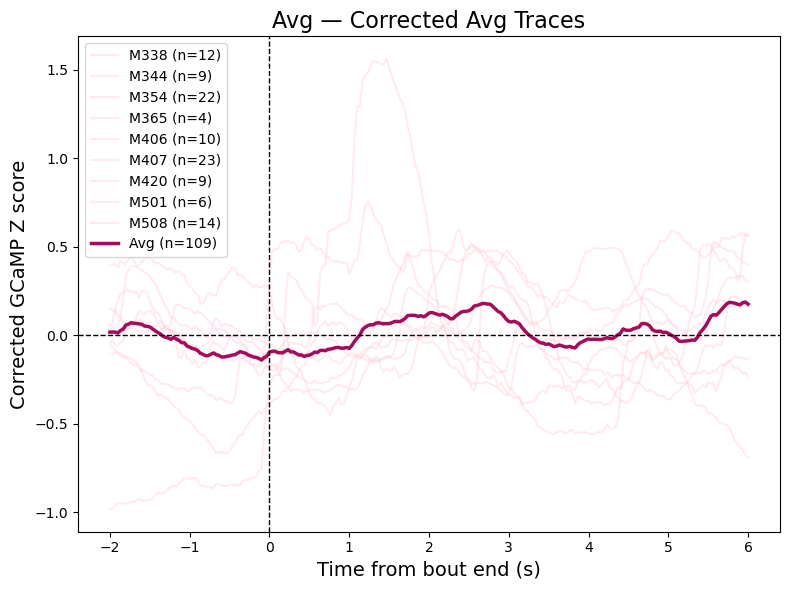

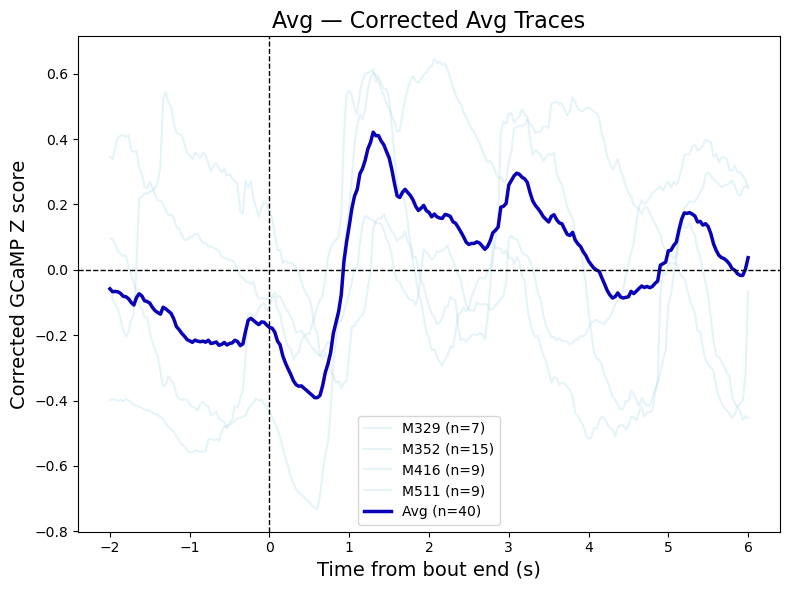

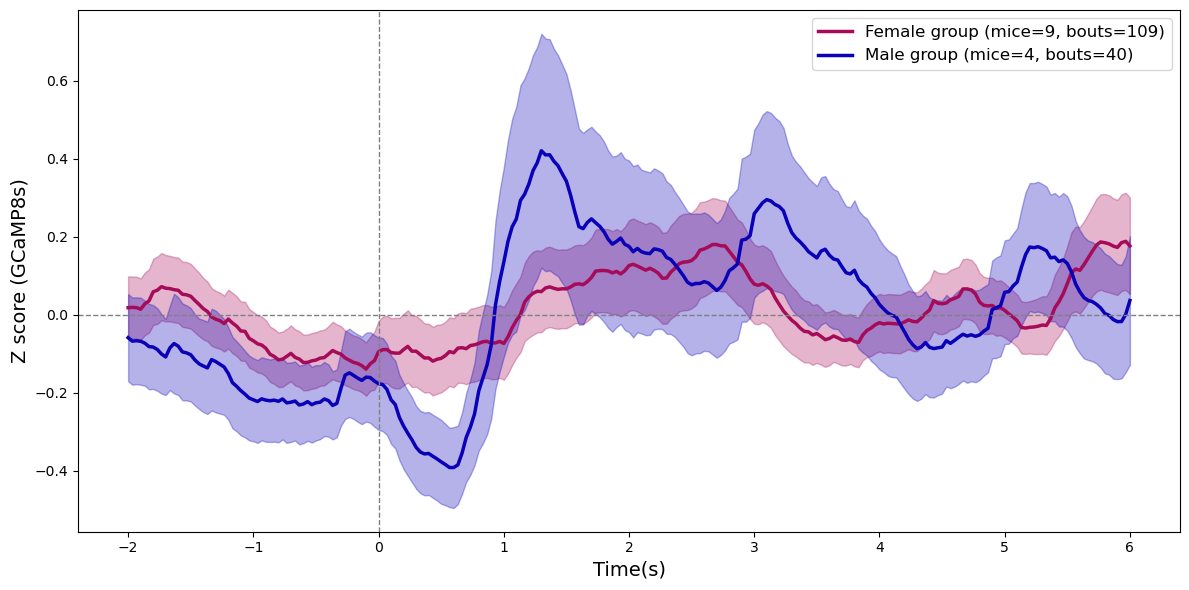

In [ ]:
    # --- Female vs Male pipeline (same steps as WT/KO) ---
    female_group, male_group = group_experiments_by_sex(experiments)

    # Female
    _, fem_bouts = detect_bouts(female_group,
                                min_duration_sec=BOUT_END_TIME,
                                max_duration_sec=999)
    fem_bouts_filt, fem_traces = filter_by_post_activity(
        female_group, fem_bouts, POST_BOUT_TIME
    )
    fem_aligned = align_traces(fem_traces, fem_bouts_filt)
    fem_mouse_avg, fem_counts, fem_gavg, fem_gstd, fem_gsem = compute_avg_traces(
        fem_aligned, common_t
    )

    # Male
    _, male_bouts = detect_bouts(male_group,
                                 min_duration_sec=BOUT_END_TIME,
                                 max_duration_sec=999)
    male_bouts_filt, male_traces = filter_by_post_activity(
        male_group, male_bouts, POST_BOUT_TIME
    )
    male_aligned = align_traces(male_traces, male_bouts_filt)
    male_mouse_avg, male_counts, male_gavg, male_gstd, male_gsem = compute_avg_traces(
        male_aligned, common_t
    )

    # Plots (sex)
    plot_female_male_corrected(common_t,
                               fem_mouse_avg, fem_counts, fem_gavg,
                               male_mouse_avg, male_counts, male_gavg)

    plot_group_avg_with_sem_sex(common_t,
                                fem_gavg, fem_gsem,
                                male_gavg, male_gsem,
                                fem_counts, male_counts,
                                n_fem_mice=len(female_group),
                                n_male_mice=len(male_group))